# CREDIT ANALYSIS PROJECT

# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining

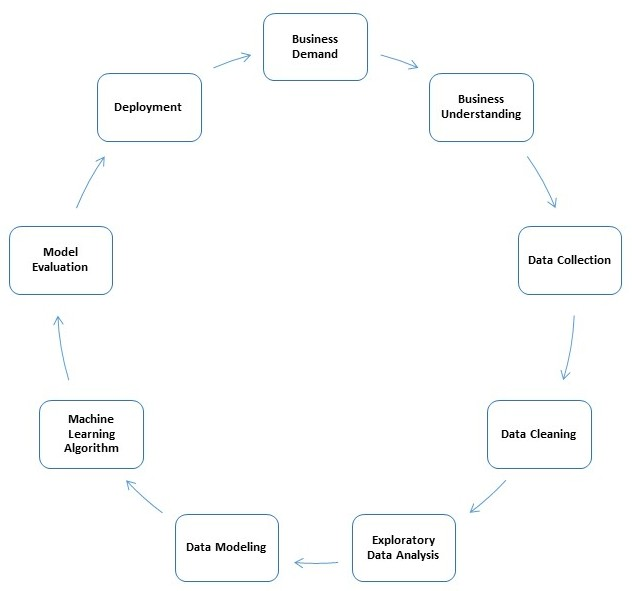

In [5]:
Image("img/crisp1.jpg")

# 0.0 IMPORTS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle

from IPython.display       import Image
from scipy                 import stats as ss
from datetime              import timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute        import  SimpleImputer
from IPython.core.display  import HTML
from boruta                import BorutaPy

# warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [3]:
def mean_percentage_error(y, yhat):
    return np.mean( ( y-yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y-yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )
def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data and check data types

In [82]:
# check datatypes
df0 = pd.read_csv('data/credit_data.csv')
# create the dict of index names and optimized datatypes
# create the dict of index names and optimized datatypes

dtypes = df0.dtypes
colnames = dtypes.index
dtypes_list = [i.name for i in dtypes.values] # transform in a list

# create datatypes dictionary
dict_column_types = dict(zip(colnames, dtypes_list))

print('{}\n\n{}'.format(df0.info(), dict_column_types ))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   int64  
 1   income      2000 non-null   float64
 2   age         1997 non-null   float64
 3   loan        2000 non-null   float64
 4   c#default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB
None

{'i#clientid': 'int64', 'income': 'float64', 'age': 'float64', 'loan': 'float64', 'c#default': 'int64'}


In [83]:
# show statistics to determine data types
df0.describe().T

,i#clientid,income,age,loan,c#default


## 0.3 Change Data Types

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255

- bool : consumes 1 byte, true or false

- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535

- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647

- float64 / int64 / uint64: consumes 8 bytes of memory

In [70]:
# Load full data with optimized datatypes

df0 = pd.read_csv('data/credit_data.csv', dtype={'i#clientid': 'uint16', 'income': 'float32', 'age': 'float16', 'loan': 'float16','c#default': 'uint8'} )
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   uint16 
 1   income      2000 non-null   float32
 2   age         1997 non-null   float16
 3   loan        2000 non-null   float16
 4   c#default   2000 non-null   uint8  
dtypes: float16(2), float32(1), uint16(1), uint8(1)
memory usage: 21.6 KB


# 1.0 DATA PREPROCESSING

In [84]:
df1 = df0.copy()

,i#clientid,income,age,loan,c#default


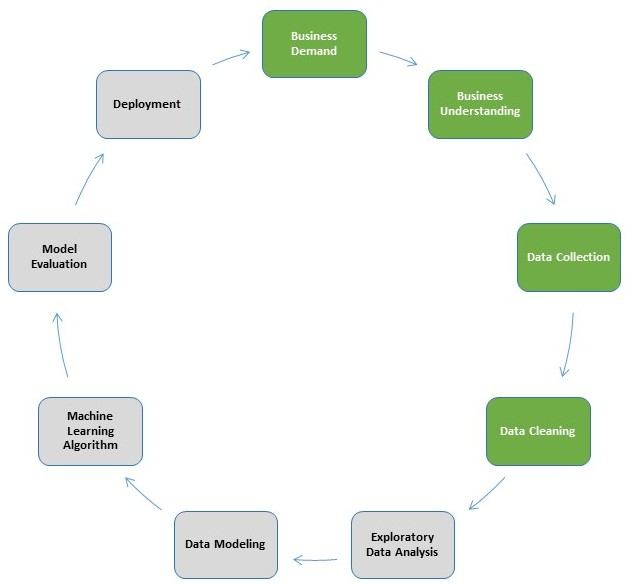

In [72]:
Image("img/crisp3.jpg")

## 1.1 Data Dimensions

In [73]:
df_shape = df1.shape
print('Number of rows: {}\nNumber of Cols: {}'.format(df_shape[0], df_shape[1]))

Number of rows: 2000
Number of Cols: 5


## 1.2 Detecting missing values

In [74]:
# check "not available" values
df1.isna().sum()

i#clientid    0
income        0
age           3
loan          0
c#default     0
dtype: int64

## 1.2 Fillout missing values

In [89]:
# filtering only missing values from age
df1[pd.isnull(df1["age"])]
df1[df1['income']<20000]


,i#clientid,income,age,loan,c#default


In [101]:
# fillout missing values

# Create object SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')

# apply SimpleImputer
si.fit(X=df1)

# reconstruct new dataframe with imputed set
df2 = pd.DataFrame.from_records(
    data=si.transform(
        X=df1
    ),  # SimpleImputer.transform(<<pandas dataframe>>) result is a list of lists
    columns=df1.columns  # keep originals columns
)

## 1.3 Treating negative ages

In [103]:
# get mean age>0
age_mean = df2['age'][df2.age>0].mean()

# applying mean to negative ages
df2.loc[df2.age < 0, 'age'] = age_mean

# 2.0 DATA DESCRIPTIONS

In [104]:
# create dataframe by data type
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

,i#clientid,income,age,loan,c#default


## 2.1 Numerical Attributes Statistics

In [105]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kutosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,i#clientid,1.000000,2000.000000,1999.000000,1000.500000,1000.500000,577.350197,0.000000,-1.200000
1,income,20014.489470,69995.685578,49981.196108,45331.600018,45789.117313,14322.745089,-0.042621,-1.201708
2,age,18.055189,63.971796,45.916607,40.927520,41.300710,13.248557,-0.016821,-1.219102
3,loan,1.377630,13766.051239,13764.673610,4444.369695,3974.719419,3044.648577,0.624284,-0.337330
4,c#default,0.000000,1.000000,1.000000,0.141500,0.000000,0.348537,2.058717,2.240556


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

<AxesSubplot:xlabel='loan'>

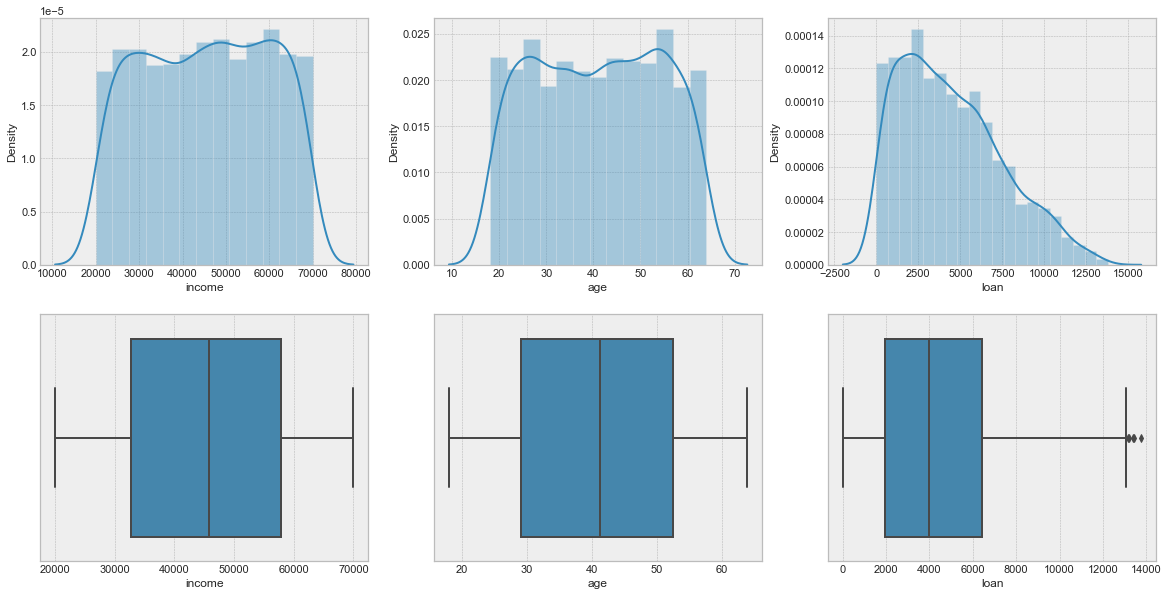

In [106]:
# mount grid 3 linesrows x 3 cols to receive charts
grid = GridSpec(2, 3)

# Distribution
plt.subplot(grid[0,0])
sns.distplot( df2['income'] )

plt.subplot(grid[0,1])
sns.distplot( df2['age'] )

plt.subplot(grid[0,2])
sns.distplot( df2['loan'] )

# Boxplot
plt.subplot(grid[1,0])
sns.boxplot( x=df2['income'])

plt.subplot(grid[1,1])
sns.boxplot( x=df2['age'] )

plt.subplot(grid[1,2])
sns.boxplot( x=df2['loan'] )

# 3.0 FEATURE ENGINEERING

## 3.1 Mind Map - Which leverages impact the granting of credit

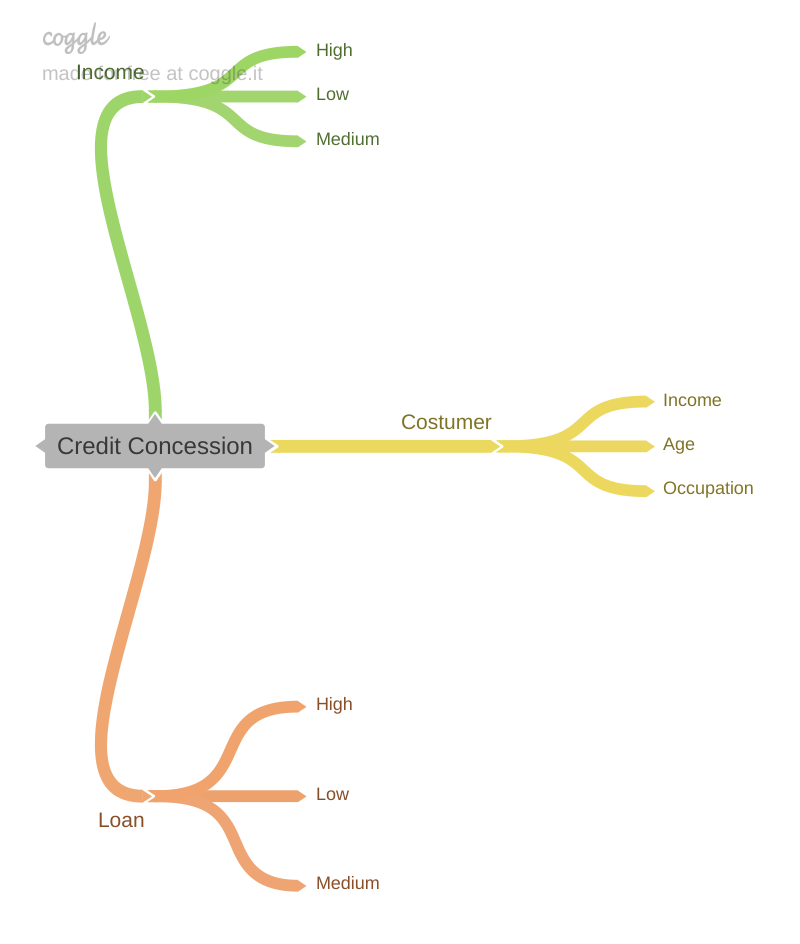

In [47]:
Image("img/Credit_Concession.png")

## 3.2 - Creating Hypotheses

### 3.2.1 - Loan Hypotheses

**1.** High Loan are less granted

**2.** Median Loan are more granted

**3.** Loans in then average area are more granted than above average

**4.** Loans are more applyed in the begining of the year. 

### 3.2.1 - Customers Hypotheses

**1.** High age customers apply for more loans.

**2.** Young customers apply for lower loans.

**3.** Median age customers apply for high loans.

**4.** Customers with higher level of studies apply less loans.

### 3.2.1 - Income Hypotheses

**1.** Low income apply for more loans.

**2.** High income apply for high loans values.

**3.** Low income are less granted.

### 3.2.1 - Hypotheses Final List

**1.** High Loan are less granted

**2.** Median Loan are more granted

**3.** Loans in then average area are more granted than above average

**4.** High age customers apply for more loans.

**5.** Young customers apply for lower loans.

**6.** Median age customers apply for high loans.

**7.** Low income apply for more loans.

**8.** High income apply for high loans values.

**9.** Low income are less granted.

## 3.3 - Feature Engineering

In [122]:
# Income
df2['income_type'] = df2['income'].apply(lambda x: 'low' if x<35000 else 'medium' if (x>=35000) & (x<50000) else 'high' )

# Age
df2['age_type'] = df2['age'].apply(lambda x: 'young' if x<=30 else 'median' if (x>30) & (x<60) else 'high' )

# loan
df2['loan_type'] = df2['loan'].apply(lambda x: 'low' if x<=2000 else 'median' if (x>2000) & (x<60000) else 'high' )

# 3.0 VARIABLE FILTERING

# 4.0 EXPLORATORY DATA ANALYSIS

# 5.0 DATA PREPARATION



# 6.0 FEATURE SELECTION

# 7.0 MACHINE LEARNING MODELLING

In [ ]:
# 0.0 IMPORTS